In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Generate Load Time Series

In [6]:
# Simulated time-series (sine wave + noise)
def generate_sine_wave(seq_length, num_samples):
    x = np.linspace(0, 2 * np.pi, seq_length)
    data = [np.sin(x + np.random.rand()) + 0.1 * np.random.randn(seq_length) for _ in range(num_samples)]
    return np.array(data)

seq_length = 50
num_samples = 1000
real_data = generate_sine_wave(seq_length, num_samples)

# Normalize to range [-1, 1]
real_data = (real_data - real_data.min()) / (real_data.max() - real_data.min())
real_data = 2 * real_data - 1

# Torch tensor
real_data = torch.tensor(real_data, dtype=torch.float32)

# Dataloader
batch_size = 32
dataset = TensorDataset(real_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Define Generator and Discriminator

In [3]:
class Generator(nn.Module):
    def __init__(self, noise_dim, seq_length):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, seq_length),
            nn.Tanh()
        )
    
    def forward(self, z):
        return self.model(z)


class Discriminator(nn.Module):
    def __init__(self, seq_length):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(seq_length, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)


Training Setup

In [4]:
noise_dim = 16
generator = Generator(noise_dim, seq_length).to(device)
discriminator = Discriminator(seq_length).to(device)

loss_fn = nn.BCELoss()
lr = 0.0002
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)


Training Loop

In [5]:
epochs = 200
for epoch in range(epochs):
    for batch in dataloader:
        real_seq = batch[0].to(device)
        batch_size = real_seq.size(0)

        # Train Discriminator
        z = torch.randn(batch_size, noise_dim).to(device)
        fake_seq = generator(z)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        d_real_loss = loss_fn(discriminator(real_seq), real_labels)
        d_fake_loss = loss_fn(discriminator(fake_seq.detach()), fake_labels)
        d_loss = d_real_loss + d_fake_loss

        discriminator.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_loss = loss_fn(discriminator(fake_seq), real_labels)

        generator.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")


Epoch 20, D Loss: 1.2724, G Loss: 0.8187
Epoch 40, D Loss: 1.3970, G Loss: 0.7076
Epoch 60, D Loss: 1.2878, G Loss: 0.7641
Epoch 80, D Loss: 1.3490, G Loss: 0.7274
Epoch 100, D Loss: 1.4377, G Loss: 0.6421
Epoch 120, D Loss: 1.3912, G Loss: 0.7014
Epoch 140, D Loss: 1.3286, G Loss: 0.7354
Epoch 160, D Loss: 1.3680, G Loss: 0.7086
Epoch 180, D Loss: 1.3743, G Loss: 0.6928
Epoch 200, D Loss: 1.3426, G Loss: 0.7369


Visualize generated data

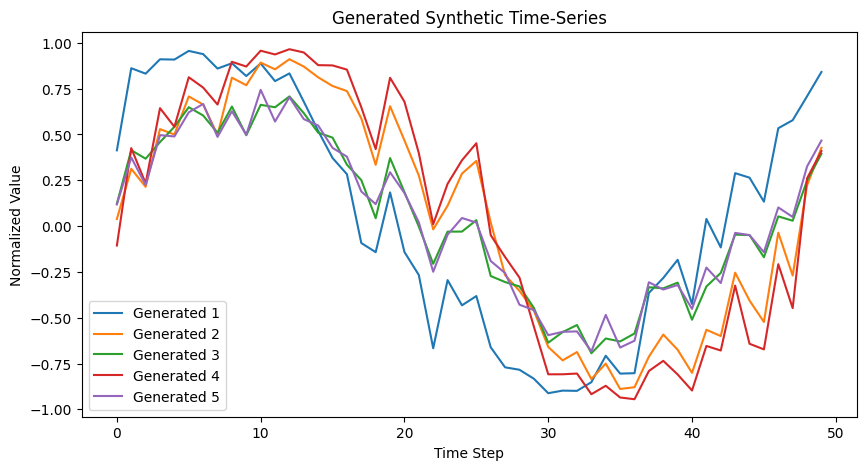

In [7]:
generator.eval()
with torch.no_grad():
    z = torch.randn(5, noise_dim).to(device)
    gen_seq = generator(z).cpu().numpy()

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(gen_seq[i], label=f"Generated {i+1}")
plt.title("Generated Synthetic Time-Series")
plt.xlabel("Time Step")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()


Real example        

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


Load Real Stock Price Data

In [3]:
# Load stock price data from Yahoo Finance
def load_stock_data(ticker="AAPL", start="2022-01-01", end="2022-12-31"):
    df = yf.download(ticker, start=start, end=end)
    prices = df["Close"].values
    prices = (prices - np.mean(prices)) / np.std(prices)  # Normalize
    return prices

real_data = load_stock_data()
sequence_length = 30

# Create sequences
def create_sequences(data, seq_len):
    sequences = [data[i:i+seq_len] for i in range(len(data)-seq_len)]
    return np.array(sequences)

sequences = create_sequences(real_data, sequence_length)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
sequences

array([[[ 2.07316322],
        [ 1.89401463],
        [ 1.52330822],
        ...,
        [ 1.32316654],
        [ 1.05293795],
        [ 1.07157465]],

       [[ 1.89401463],
        [ 1.52330822],
        [ 1.29685505],
        ...,
        [ 1.05293795],
        [ 1.07157465],
        [ 1.37519471]],

       [[ 1.52330822],
        [ 1.29685505],
        [ 1.31003608],
        ...,
        [ 1.07157465],
        [ 1.37519471],
        [ 1.35655439]],

       ...,

       [[-0.47597133],
        [-0.33868488],
        [-0.43618983],
        ...,
        [-1.72792725],
        [-1.75678897],
        [-1.8995335 ]],

       [[-0.33868488],
        [-0.43618983],
        [-0.28564288],
        ...,
        [-1.75678897],
        [-1.8995335 ],
        [-2.21076694]],

       [[-0.43618983],
        [-0.28564288],
        [-0.24117993],
        ...,
        [-1.8995335 ],
        [-2.21076694],
        [-1.93229523]]])

Create GAN (Generator & Discriminator) - Modifying code for WGAN-GP

In [5]:
class Generator(nn.Module):
    def __init__(self, noise_dim, seq_len):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, seq_len)
        )

    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(seq_len, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # No sigmoid here!
        )

    def forward(self, x):
        return self.net(x)


Defining Gradient Penalty

In [6]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1).to(device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(d_interpolates.size()).to(device)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp


Train GAN

In [7]:
# Settings
device = "cuda" if torch.cuda.is_available() else "cpu"
noise_dim = 30
batch_size = 32
epochs = 1000

# Prepare data
tensor_data = torch.tensor(sequences, dtype=torch.float32)
loader = DataLoader(TensorDataset(tensor_data), batch_size=batch_size, shuffle=True)

# Models
G = Generator(noise_dim, sequence_length).to(device)
D = Discriminator(sequence_length).to(device)

# Optimizers & loss
# criterion = nn.BCELoss()
# opt_G = torch.optim.Adam(G.parameters(), lr=0.001)
# opt_D = torch.optim.Adam(D.parameters(), lr=0.001)
opt_G = torch.optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.9))
opt_D = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.9))


# Training loop
# for epoch in range(epochs):
#     for real_batch, in loader:
#         real_batch = real_batch.to(device).view(real_batch.size(0), -1)

#         # Train Discriminator
#         z = torch.randn(real_batch.size(0), noise_dim).to(device)
#         fake_batch = G(z)

#         real_labels = torch.ones(real_batch.size(0), 1).to(device)
#         fake_labels = torch.zeros(real_batch.size(0), 1).to(device)

#         D_real = D(real_batch)
#         D_fake = D(fake_batch.detach())
#         loss_D = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)

#         opt_D.zero_grad()
#         loss_D.backward()
#         opt_D.step()

#         # Train Generator
#         D_fake = D(fake_batch)
#         loss_G = criterion(D_fake, real_labels)  # Fooling the discriminator

#         opt_G.zero_grad()
#         loss_G.backward()
#         opt_G.step()

#     if (epoch+1) % 10 == 0:
#         print(f"Epoch {epoch+1}, Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")



lambda_gp = 10

for epoch in range(epochs):
    for real_batch in loader:
        real = real_batch[0].to(device)
        batch_size = real.size(0)  # Update batch_size dynamically
        real = real.view(batch_size, -1)  # Flatten the input
        batch_size = real.size(0)

        # ======== Train Discriminator ========
        for _ in range(5):  # More D updates per G update
            z = torch.randn(batch_size, noise_dim).to(device)
            fake = G(z).detach()
            d_real = D(real).mean()
            d_fake = D(fake).mean()
            gp = compute_gradient_penalty(D, real.data, fake.data)
            d_loss = -d_real + d_fake + lambda_gp * gp

            opt_D.zero_grad()
            d_loss.backward()
            opt_D.step()

        # ======== Train Generator ========
        z = torch.randn(batch_size, noise_dim).to(device)
        gen_data = G(z)
        g_loss = -D(gen_data).mean()

        opt_G.zero_grad()
        g_loss.backward()
        opt_G.step()

    # Logging (optional)
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f}")



Epoch 0 | D_loss: 4.9678 | G_loss: 0.0413
Epoch 100 | D_loss: -3.4052 | G_loss: -0.5074
Epoch 200 | D_loss: -0.7963 | G_loss: -3.1344
Epoch 300 | D_loss: -0.6122 | G_loss: 0.0083
Epoch 400 | D_loss: -0.2906 | G_loss: 1.2901
Epoch 500 | D_loss: -0.4340 | G_loss: 2.1737
Epoch 600 | D_loss: -0.5702 | G_loss: 3.6084
Epoch 700 | D_loss: -0.9932 | G_loss: 4.7546
Epoch 800 | D_loss: -0.8542 | G_loss: 5.4165
Epoch 900 | D_loss: -0.6527 | G_loss: 6.7341


Plot

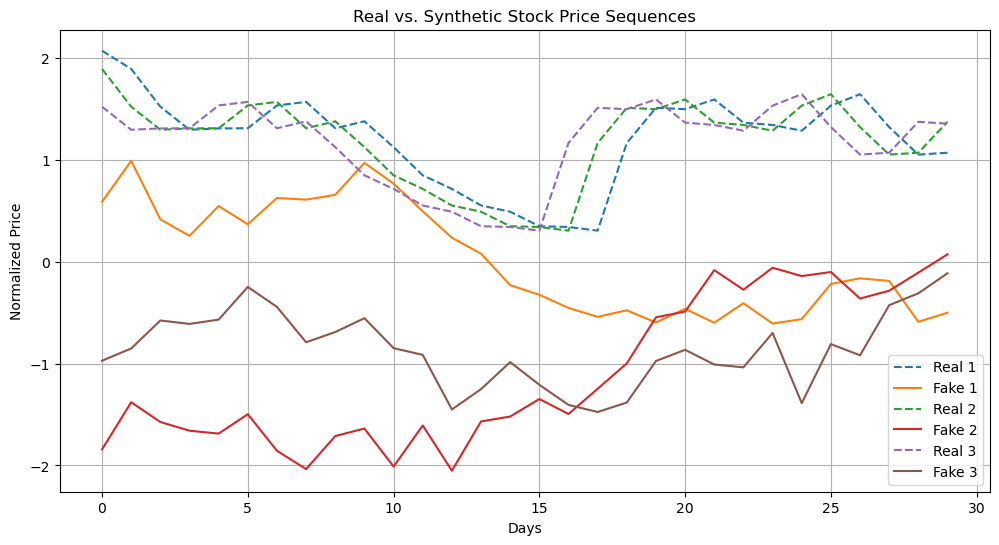

In [8]:
# Generate synthetic sequences
with torch.no_grad():
    z = torch.randn(100, noise_dim).to(device)
    synthetic_sequences = G(z).cpu().numpy()

# Plot a few samples
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.plot(sequences[i], label=f"Real {i+1}", linestyle='dashed')
    plt.plot(synthetic_sequences[i], label=f"Fake {i+1}")
plt.legend()
plt.title("Real vs. Synthetic Stock Price Sequences")
plt.xlabel("Days")
plt.ylabel("Normalized Price")
plt.grid(True)
plt.show()


# **Financial GANs**

Overview of GAN Models for Financial Time Series
1. TimeGAN

    Architecture: Combines autoencoding with adversarial training, incorporating an embedder, recovery, generator, supervisor, and discriminator.

    Strengths: Captures both temporal dynamics and data distribution effectively.

    Use Case: Suitable for generating realistic time series data while preserving temporal dependencies.

2. QuantGAN

    Architecture: Utilizes Temporal Convolutional Networks (TCNs) for both generator and discriminator.

    Strengths: Efficiently models long-range dependencies in time series data.

    Use Case: Ideal for generating financial time series data with a focus on capturing stylized facts.
    ResearchGate+1arXiv+1
    arXiv+1ResearchGate+1

3. WGAN-GP (Wasserstein GAN with Gradient Penalty)

    Architecture: Employs a Wasserstein loss with gradient penalty to improve training stability.

    Strengths: Addresses issues like mode collapse and training instability common in traditional GANs.

    Use Case: Applicable for generating diverse and stable synthetic time series data.
    GitHub

4. FIN-GAN

    Architecture: Incorporates an economics-driven loss function tailored for financial forecasting and classification tasks.

    Strengths: Combines generative modeling with supervised learning objectives.

    Use Case: Designed for probabilistic forecasting and classification of financial time series.

In [88]:
basepath = Path.cwd()
basepath

PosixPath('/home/sobottka/BSE/Master_Thesis/bse-thesis-synthetic-data')

In [89]:
filepath = basepath / "data" / "nvidia_2020_2021.csv"

In [92]:
pd2 = pd.read_csv(filepath, header=[0,1], index_col=0, parse_dates=True)
pd2.head()

Price,Open,High,Low,Close,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2020-01-02,5.94,5.97,5.89,5.97,237536000
2020-01-03,5.85,5.92,5.83,5.88,205384000
2020-01-06,5.78,5.91,5.76,5.90,262636000
2020-01-07,5.93,6.02,5.88,5.97,314856000
2020-01-08,5.97,6.03,5.93,5.98,277108000


In [94]:
pd2['log_price'] = np.log(pd2['Close','NVDA'])
pd2.head()

Price,Open,High,Low,Close,Volume,log_price
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,
Date,,,,,,
2020-01-02,5.94,5.97,5.89,5.97,237536000,1.786747
2020-01-03,5.85,5.92,5.83,5.88,205384000,1.771557
2020-01-06,5.78,5.91,5.76,5.90,262636000,1.774952
2020-01-07,5.93,6.02,5.88,5.97,314856000,1.786747
2020-01-08,5.97,6.03,5.93,5.98,277108000,1.788421


In [102]:
pd2['log_return'] = pd2['log_price'] - pd2['log_price'].shift(1)
pd2['log_return'].head()

Date
2020-01-02         NaN
2020-01-03   -0.015190
2020-01-06    0.003396
2020-01-07    0.011795
2020-01-08    0.001674
Name: log_return, dtype: float64

##  TimeGAN

[*********************100%***********************]  1 of 1 completed


Epoch 0 | D_loss: 1.3318 | G_loss: 0.6880


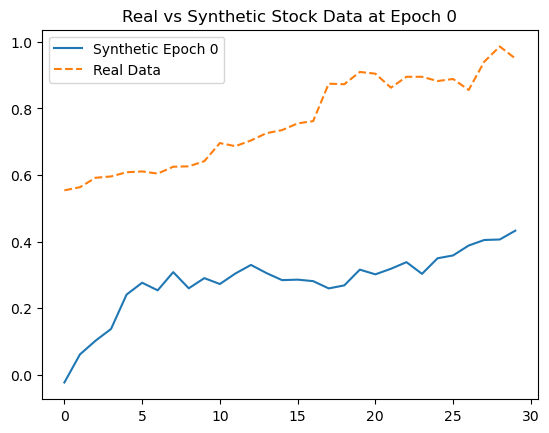

Epoch 100 | D_loss: 1.3892 | G_loss: 0.6948
Epoch 200 | D_loss: 1.3972 | G_loss: 0.7035


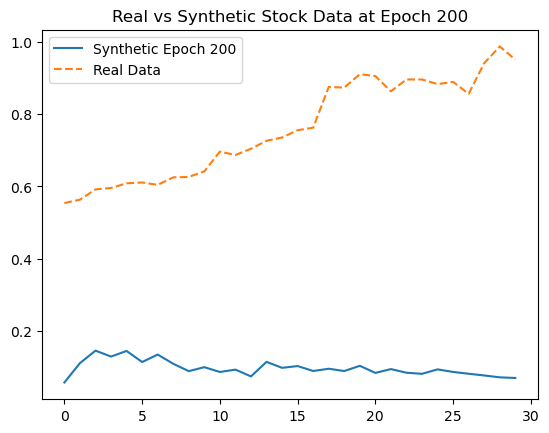

Epoch 300 | D_loss: 1.4033 | G_loss: 0.6933
Epoch 400 | D_loss: 1.3818 | G_loss: 0.6390


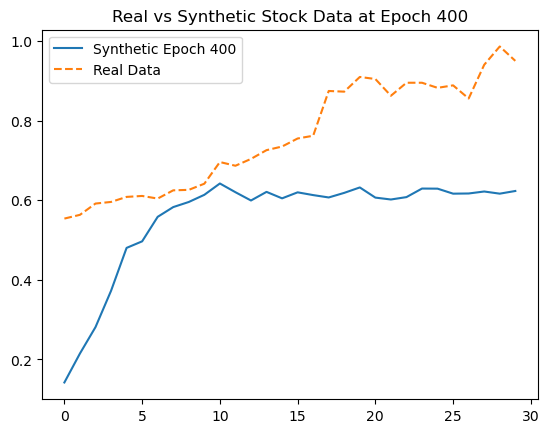

Epoch 500 | D_loss: 1.4240 | G_loss: 0.6810
Epoch 600 | D_loss: 1.4301 | G_loss: 0.7317


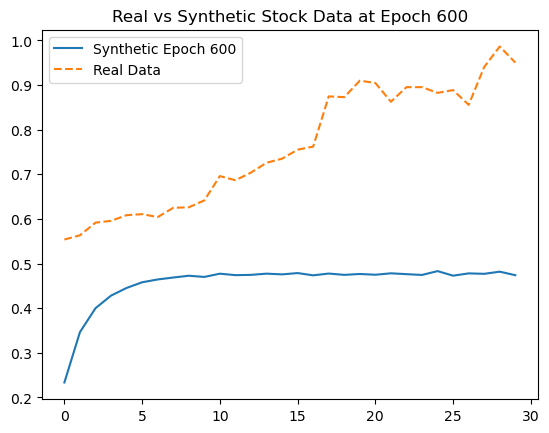

Epoch 700 | D_loss: 1.3457 | G_loss: 0.6713
Epoch 800 | D_loss: 1.4082 | G_loss: 0.6886


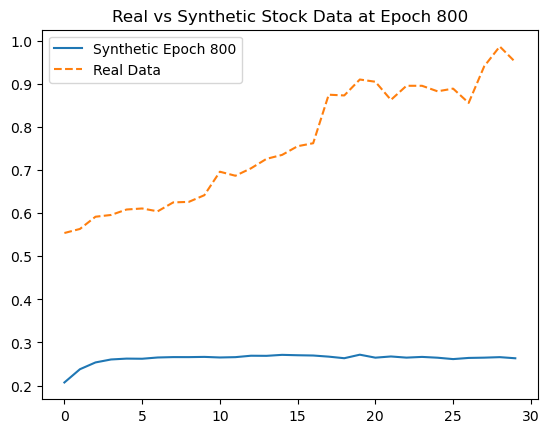

Epoch 900 | D_loss: 1.4200 | G_loss: 0.7041


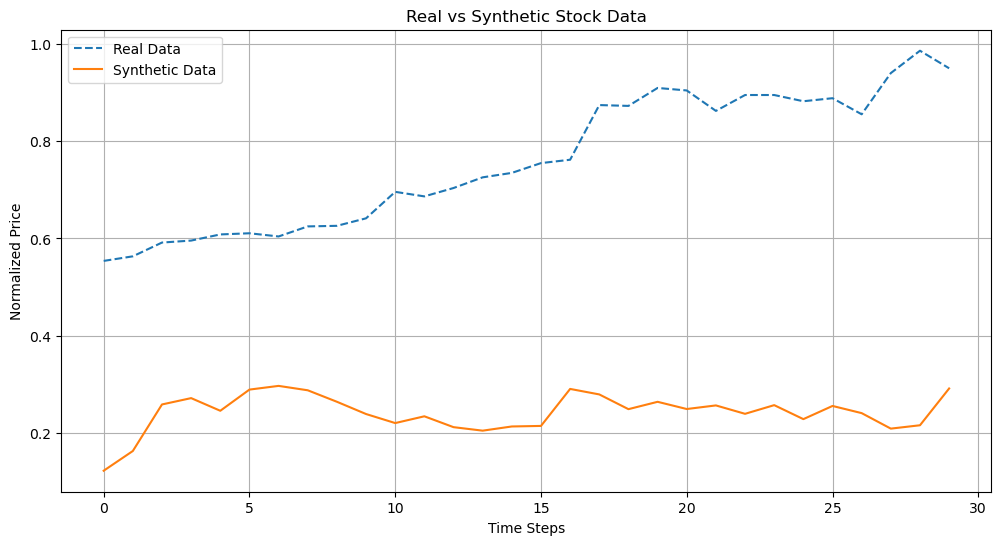

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


# 1. Prepare Data
def load_stock_data(ticker="NVDA", start="2020-01-01", end="2022-01-01"):
    df = yf.download(ticker, start=start, end=end)
    prices = df["Close"].values
    prices = prices.reshape(-1, 1)  # Reshape to 2D
    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(prices)  # Normalize data
    return scaled_prices

# Load NVIDIA stock data
real_data = load_stock_data()

# Create sequences (example: 30 days of data)
sequence_length = 30
def create_sequences(data, seq_len):
    sequences = [data[i:i+seq_len] for i in range(len(data)-seq_len)]
    return np.array(sequences)

sequences = create_sequences(real_data, sequence_length)
sequences = torch.tensor(sequences, dtype=torch.float32)


# 2. Define Models (Encoder, Recovery, Generator, Discriminator)

# Encoder: LSTM autoencoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, seq_len)

    def forward(self, x):
        h, (hn, cn) = self.lstm(x)
        z = self.fc(hn[-1])
        return z

class Recovery(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super(Recovery, self).__init__()
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, h):
        h_out, _ = self.lstm(h)
        x_tilde = self.fc(h_out)
        return x_tilde

class Supervisor(nn.Module):
    def __init__(self, hidden_dim):
        super(Supervisor, self).__init__()
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)

    def forward(self, h):
        h_hat, _ = self.lstm(h)
        return h_hat



# Generator: LSTM generator
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len):
        super(Generator, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, input_dim)  # OUTPUT one value per time step

    def forward(self, z):
        h, _ = self.lstm(z)  # shape: [batch_size, seq_len, hidden_dim]
        x_gen = self.fc(h)   # shape: [batch_size, seq_len, input_dim]
        return x_gen


# Discriminator: LSTM discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len):
        super(Discriminator, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h, _ = self.lstm(x)
        validity = self.fc(h[:, -1])  # Use last output of LSTM for classification
        return validity

# 3. Initialize Models and Optimizers
input_dim = 1  # Stock prices are a 1D time series
hidden_dim = 64
seq_len = sequence_length
lr = 0.001

encoder = Encoder(input_dim, hidden_dim, seq_len)
generator = Generator(input_dim, hidden_dim, seq_len)
discriminator = Discriminator(input_dim, hidden_dim, seq_len)

optimizer_E = optim.Adam(encoder.parameters(), lr=lr)
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Loss function
criterion = nn.BCEWithLogitsLoss()  # For binary classification (real or fake)

# 4. Training Loop (TimeGAN Training)
epochs = 1000
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder.to(device)
generator.to(device)
discriminator.to(device)

sequences = sequences.to(device)

for epoch in range(epochs):
    for i in range(0, len(sequences), batch_size):
        # Create mini-batch
        real_batch = sequences[i:i+batch_size]
        
        # ===== Train Discriminator =====
          # Ensure z has the correct shape
        z = torch.randn(real_batch.size(0), sequence_length, input_dim).to(device)

        fake_batch = generator(z)

        # Real labels are 1, fake labels are 0
        real_labels = torch.ones(real_batch.size(0), 1).to(device)
        fake_labels = torch.zeros(real_batch.size(0), 1).to(device)

        # Forward pass
        D_real = discriminator(real_batch)
        D_fake = discriminator(fake_batch.detach())

        # Discriminator loss
        D_loss_real = criterion(D_real, real_labels)
        D_loss_fake = criterion(D_fake, fake_labels)
        D_loss = D_loss_real + D_loss_fake

        # Backpropagate discriminator loss
        optimizer_D.zero_grad()
        D_loss.backward()
        optimizer_D.step()

        # ===== Train Generator =====
        D_fake = discriminator(fake_batch)
        G_loss = criterion(D_fake, real_labels)  # Fool the discriminator

        # Backpropagate generator loss
        optimizer_G.zero_grad()
        G_loss.backward()
        optimizer_G.step()

    # Logging
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | D_loss: {D_loss.item():.4f} | G_loss: {G_loss.item():.4f}")

    # Optionally, generate synthetic data every 200 epochs
    if epoch % 200 == 0:
        with torch.no_grad():
            z = torch.randn(10, sequence_length, input_dim).to(device)  # Ensure z has the correct shape
            synthetic_data = generator(z).cpu().numpy()
            plt.plot(synthetic_data[0], label=f"Synthetic Epoch {epoch}")
            plt.plot(real_batch[0].cpu().numpy(), label="Real Data", linestyle="--")
            plt.legend()
            plt.title(f"Real vs Synthetic Stock Data at Epoch {epoch}")
            plt.show()

# 5. Evaluate Model (Optional)
with torch.no_grad():
    z = torch.randn(100, sequence_length, input_dim).to(device)
    synthetic_data = generator(z).cpu().numpy()


# Plot synthetic vs real data
plt.figure(figsize=(12, 6))
plt.plot(real_batch[0].cpu().numpy(), label="Real Data", linestyle="-")
plt.plot(synthetic_data[0], label="Synthetic Data", linestyle="-")
plt.legend()
plt.title("Real vs Synthetic Stock Data")
plt.xlabel("Time Steps")
plt.ylabel("Normalized Price")
plt.grid(True)
plt.show()


In [107]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import os
from pathlib import Path

def load_stock_data(file_name="nvidia_2020_2021.csv"):
    # Get the path relative to this script's location
    base_path = Path.cwd()
    file_path = base_path / "data" / file_name

    if not file_path.exists():
        raise FileNotFoundError(f"{file_path} not found. Please pull the repo with the data folder.")

    # Read CSV with multi-index header (2 rows)
    df = pd.read_csv(file_path, header=[0,1], index_col=0, parse_dates=True)

    if df.empty or df.isnull().all().all():
        raise ValueError(f"File {file_name} is empty or contains only NaNs.")

    # Access the 'Close' price for 'NVDA' ticker (second level)
    df['log_price'] = np.log(df[('Close', 'NVDA')])
    df['log_return'] = df['log_price'].diff()
    df.dropna(inplace=True)  # Drop NaN values
    dates = df.index.to_list()

    scaler = MinMaxScaler()
    scaled_returns = scaler.fit_transform(df[['log_return']])  # Note: Double brackets for 2D input

    return scaled_returns, dates, scaler

def create_sequences(data, seq_len):
    return np.array([data[i:i+seq_len] for i in range(len(data)-seq_len)])

# 2. Define TimeGAN Components
class Embedder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        h, _ = self.lstm(x)
        return h

class Recovery(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, h):
        h_out, _ = self.lstm(h)
        return self.fc(h_out)

class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, z):
        h, _ = self.lstm(z)
        return self.fc(h)

class Supervisor(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)

    def forward(self, h):
        h_hat, _ = self.lstm(h)
        return h_hat

class Discriminator(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, h):
        h_out, _ = self.lstm(h)
        return self.fc(h_out[:, -1])


In [108]:
# 3. Training Setup
input_dim = 1
hidden_dim = 64
seq_len = 100
lr = 0.001
batch_size = 64
epochs = 5000

real_data, dates, scaler = load_stock_data()
sequences = create_sequences(real_data, seq_len)
sequences = torch.tensor(sequences, dtype=torch.float32)
sequence_dates = dates[:len(sequences)]  # list of starting dates for each sequence
plot_dates = dates[:seq_len]  # The first 30 dates

# Models
embedder = Embedder(input_dim, hidden_dim)
recovery = Recovery(hidden_dim, input_dim)
generator = Generator(hidden_dim, hidden_dim)
supervisor = Supervisor(hidden_dim)
discriminator = Discriminator(hidden_dim)

# Optimizers
e_optimizer = optim.Adam(list(embedder.parameters()) + list(recovery.parameters()), lr=lr)
g_optimizer = optim.Adam(list(generator.parameters()) + list(supervisor.parameters()), lr=lr)
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)

# For tracking losses
embedder_losses = []
supervisor_losses = []
generator_losses = []
discriminator_losses = []

# Losses
mse = nn.MSELoss()
bce = nn.BCEWithLogitsLoss()

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedder.to(device)
recovery.to(device)
generator.to(device)
supervisor.to(device)
discriminator.to(device)
sequences = sequences.to(device)



Starting Phase 3: Joint Training...

Epoch [1/5000] | D_loss: 1.3531 | G_loss: 136.5984 (U: 0.7319, S: 0.1266, V: 1.2321)
Epoch [2/5000] | D_loss: 1.2649 | G_loss: 143.3448 (U: 0.8395, S: 0.1725, V: 1.2526)
Epoch [3/5000] | D_loss: 1.0807 | G_loss: 144.9995 (U: 1.1583, S: 0.1841, V: 1.2543)
Epoch [4/5000] | D_loss: 0.7102 | G_loss: 148.3152 (U: 2.1588, S: 0.1921, V: 1.2695)
Epoch [5/5000] | D_loss: 0.3438 | G_loss: 154.8185 (U: 3.1402, S: 0.1980, V: 1.3187)
Epoch [6/5000] | D_loss: 0.2189 | G_loss: 163.3332 (U: 3.5234, S: 0.2006, V: 1.3975)
Epoch [7/5000] | D_loss: 0.4362 | G_loss: 166.6644 (U: 3.5384, S: 0.1971, V: 1.4341)
Epoch [8/5000] | D_loss: 0.4997 | G_loss: 161.0153 (U: 3.7800, S: 0.1995, V: 1.3729)
Epoch [9/5000] | D_loss: 0.2035 | G_loss: 158.6331 (U: 4.4206, S: 0.2493, V: 1.2928)
Epoch [10/5000] | D_loss: 0.0934 | G_loss: 153.3934 (U: 4.7576, S: 0.2586, V: 1.2277)
Epoch [11/5000] | D_loss: 0.0884 | G_loss: 150.9755 (U: 4.8828, S: 0.2603, V: 1.2007)
Epoch [12/5000] | D_loss:

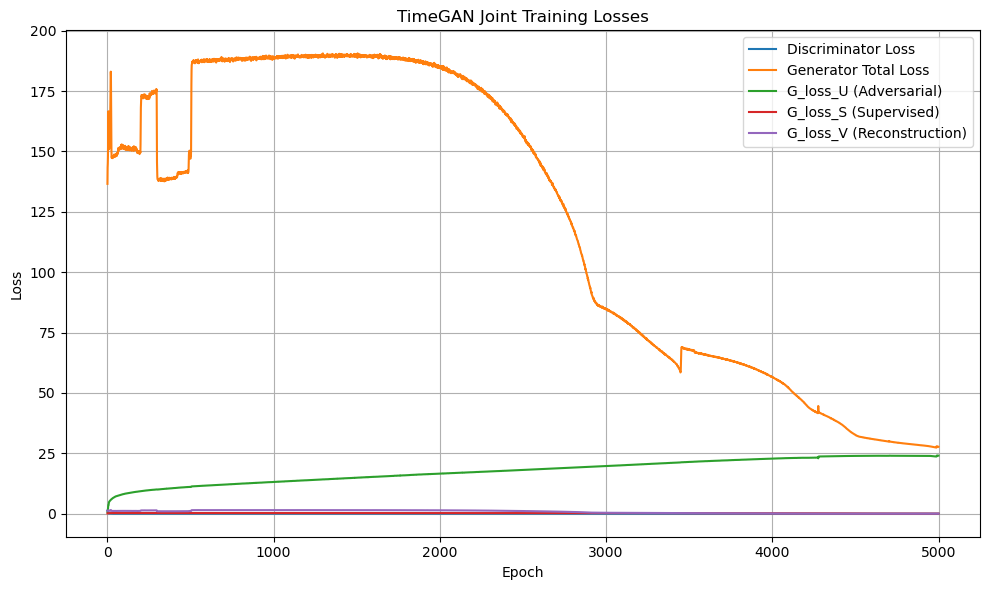

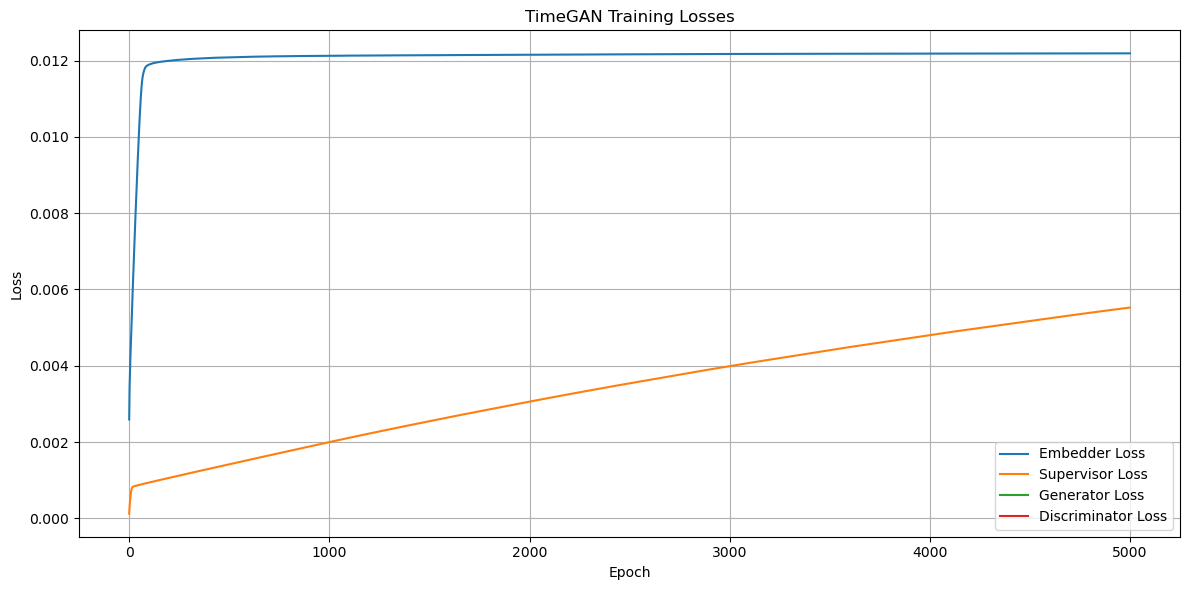

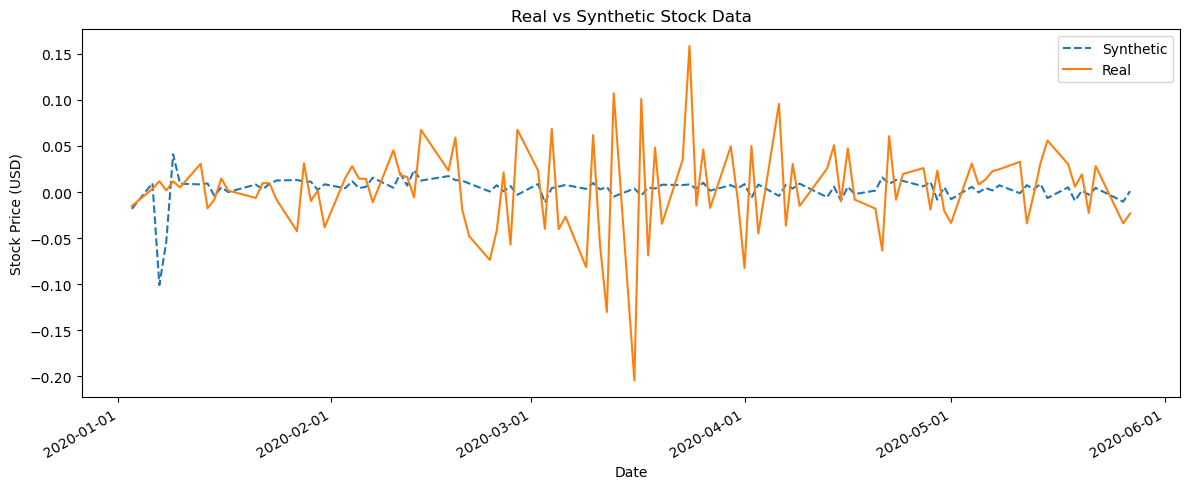

In [109]:
# 4. Phase 1: Embedder Training
total_e_loss = 0
for epoch in range(5000):
    for i in range(0, len(sequences), batch_size):
        X = sequences[i:i+batch_size]
        H = embedder(X)
        X_tilde = recovery(H)
        L_e = mse(X, X_tilde)
        e_optimizer.zero_grad()
        L_e.backward()
        e_optimizer.step()
        total_e_loss += L_e.item()
    embedder_losses.append(total_e_loss / len(sequences))


# 5. Phase 2: Supervisor Training
total_s_loss = 0
for epoch in range(5000):
    for i in range(0, len(sequences), batch_size):
        X = sequences[i:i+batch_size]
        H = embedder(X)
        H_hat_supervise = supervisor(H)
        L_s = mse(H[:, 1:], H_hat_supervise[:, :-1])
        g_optimizer.zero_grad()
        L_s.backward()
        g_optimizer.step()
        total_s_loss += L_s.item()
    supervisor_losses.append(total_s_loss / len(sequences))


# 6. Phase 3: Joint Training with Loss Tracking
all_d_losses = []
all_g_losses = []
all_g_loss_u = []
all_g_loss_s = []
all_g_loss_v = []

print("\nStarting Phase 3: Joint Training...\n")
for epoch in range(5000):
    epoch_d_loss = 0
    epoch_g_loss = 0
    epoch_g_u = 0
    epoch_g_s = 0
    epoch_g_v = 0
    batches = 0

    for i in range(0, len(sequences), batch_size):
        batches += 1
        X = sequences[i:i+batch_size]

        # Forward passes
        H = embedder(X)
        H_hat_supervise = supervisor(H)
        X_tilde = recovery(H)

        # Generator forward
        Z = torch.randn(X.size(0), seq_len, hidden_dim).to(device)
        E_hat = generator(Z)
        H_hat = supervisor(E_hat)
        X_hat = recovery(H_hat)

        # Discriminator Loss
        Y_real = torch.ones(X.size(0), 1).to(device)
        Y_fake = torch.zeros(X.size(0), 1).to(device)

        D_real = discriminator(H.detach())
        D_fake = discriminator(H_hat.detach())

        D_loss_real = bce(D_real, Y_real)
        D_loss_fake = bce(D_fake, Y_fake)
        D_loss = D_loss_real + D_loss_fake
        d_optimizer.zero_grad()
        D_loss.backward()
        d_optimizer.step()

        # Generator Loss
        D_fake = discriminator(H_hat)
        G_loss_U = bce(D_fake, Y_real)
        G_loss_S = mse(H[:, 1:], H_hat_supervise[:, :-1])
        G_loss_V = mse(X, X_hat)
        G_loss = G_loss_U + 100 * torch.sqrt(G_loss_S) + 100 * G_loss_V

        g_optimizer.zero_grad()
        G_loss.backward()
        g_optimizer.step()

        # Accumulate for epoch tracking
        epoch_d_loss += D_loss.item()
        epoch_g_loss += G_loss.item()
        epoch_g_u += G_loss_U.item()
        epoch_g_s += torch.sqrt(G_loss_S).item()
        epoch_g_v += G_loss_V.item()

    # Average loss per batch for this epoch
    avg_d_loss = epoch_d_loss / batches
    avg_g_loss = epoch_g_loss / batches
    avg_g_u = epoch_g_u / batches
    avg_g_s = epoch_g_s / batches
    avg_g_v = epoch_g_v / batches

    all_d_losses.append(avg_d_loss)
    all_g_losses.append(avg_g_loss)
    all_g_loss_u.append(avg_g_u)
    all_g_loss_s.append(avg_g_s)
    all_g_loss_v.append(avg_g_v)

    print(f"Epoch [{epoch+1}/{epochs}] | D_loss: {avg_d_loss:.4f} | G_loss: {avg_g_loss:.4f} "
          f"(U: {avg_g_u:.4f}, S: {avg_g_s:.4f}, V: {avg_g_v:.4f})")




# 7. Synthetic Data Generation
generator.eval()
supervisor.eval()
recovery.eval()

# Z = torch.randn(n_samples, target_length, hidden_dim).to(device)
Z = torch.randn(1, seq_len, hidden_dim).to(device) #random noise
E_hat = generator(Z) #Data generated from noise (E_hat) (Learn temporal dependencies)
H_hat = supervisor(E_hat) # Data for the next step (H_hat)
X_hat = recovery(H_hat).detach().cpu().numpy()

# Denormalize Synthetic Data

synthetic_sequence = X_hat[0] # Reshape to 2D for inverse transform
denormalized_synthetic = scaler.inverse_transform(synthetic_sequence)

#Denormalize Real Data
real_sequence = sequences[0].detach().cpu().numpy()  # shape: (seq_len, 1)
denormalized_real = scaler.inverse_transform(real_sequence)

# Plotting denormalized data with date as x-axis
import matplotlib.dates as mdates


# Plot the losses
plt.figure(figsize=(10,6))
plt.plot(all_d_losses, label='Discriminator Loss')
plt.plot(all_g_losses, label='Generator Total Loss')
plt.plot(all_g_loss_u, label='G_loss_U (Adversarial)')
plt.plot(all_g_loss_s, label='G_loss_S (Supervised)')
plt.plot(all_g_loss_v, label='G_loss_V (Reconstruction)')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("TimeGAN Joint Training Losses")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(embedder_losses, label='Embedder Loss')
plt.plot(supervisor_losses, label='Supervisor Loss')
plt.plot(generator_losses, label='Generator Loss')
plt.plot(discriminator_losses, label='Discriminator Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("TimeGAN Training Losses")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 5))
plt.plot(plot_dates, denormalized_synthetic, label="Synthetic", linestyle="--")
plt.plot(plot_dates, denormalized_real, label="Real", linestyle="-")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.title("Real vs Synthetic Stock Data")
plt.legend()
plt.tight_layout()
plt.show()




### Saving Generator, Embedder, Recovery, Supervisor and Discriminator

In [117]:
torch.save(generator.state_dict(), "generator.pth")
torch.save(embedder.state_dict(), "embedder.pth")
torch.save(recovery.state_dict(), "recovery.pth")
torch.save(supervisor.state_dict(), "supervisor.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")


/tmp/ipykernel_47505/246390869.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Type', y='Returns',


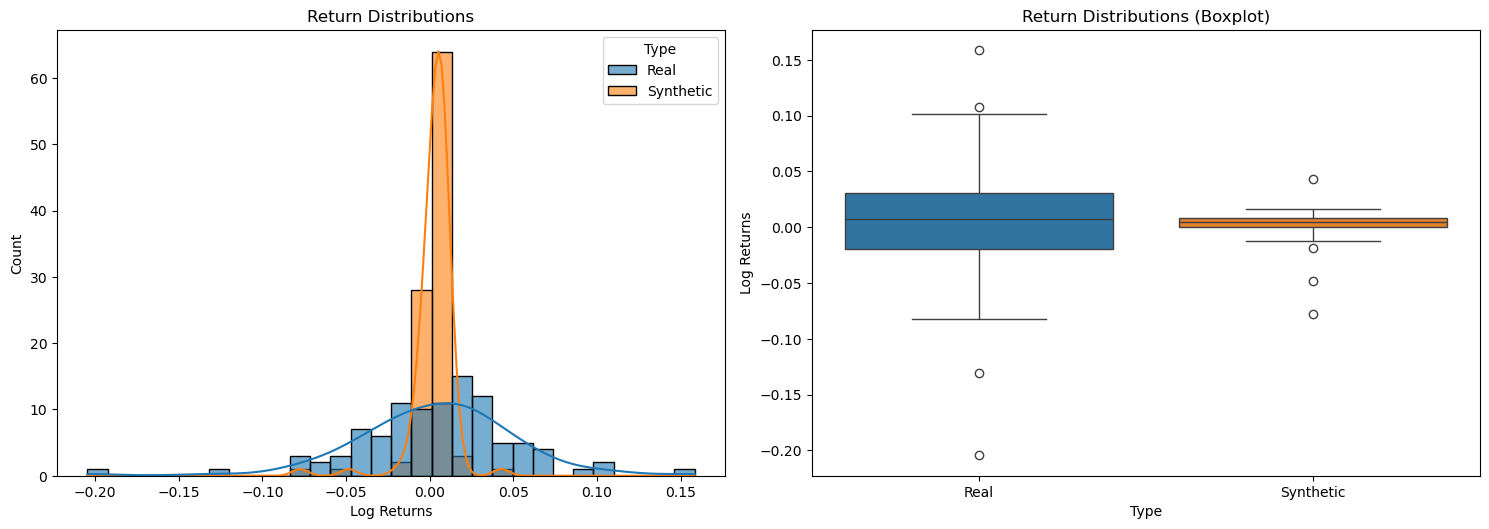


BASIC STATISTICS COMPARISON
       Real Returns  Synthetic Returns
count    100.000000         100.000000
mean       0.003521           0.002932
std        0.048509           0.012028
min       -0.204567          -0.077409
25%       -0.019606          -0.000272
50%        0.006974           0.004708
75%        0.030337           0.007848
max        0.158454           0.042815

STATISTICAL TESTS

Kolmogorov-Smirnov Test:
  Statistic: 0.4100
  p-value: 0.0000

T-test (Welch's):
  Statistic: 0.1180
  p-value: 0.9063


In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.dates as mdates

def plot_and_analyze(sequences, synthetic_data, scaler, plot_dates):
    """
    Generate the 4 requested plots and statistical tests
    """
    # 1. Prepare the data
    synthetic_sequence = synthetic_data[0]
    denormalized_synthetic = scaler.inverse_transform(synthetic_sequence)
    
    real_sequence = sequences[0].detach().cpu().numpy()
    denormalized_real = scaler.inverse_transform(real_sequence)
    
    # Convert to price series
    def returns_to_prices(returns):
        log_prices = np.cumsum(returns)
        return np.exp(log_prices) * 100  # Base price of 100
    
    real_prices = returns_to_prices(denormalized_real)
    synthetic_prices = returns_to_prices(denormalized_synthetic)
    
    # Create DataFrame
    df = pd.DataFrame({
        'Returns': np.concatenate([denormalized_real.flatten(), 
                                 denormalized_synthetic.flatten()]),
        'Prices': np.concatenate([real_prices.flatten(), 
                                synthetic_prices.flatten()]),
        'Type': ['Real']*len(denormalized_real) + ['Synthetic']*len(denormalized_synthetic),
        'Date': np.concatenate([plot_dates[:len(denormalized_real)], 
                               plot_dates[:len(denormalized_synthetic)]])
    })

    # ======================
    # 2. Generate the Plots
    # ======================
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Return distributions (histogram)
    plt.subplot(2, 2, 1)
    sns.histplot(data=df, x='Returns', hue='Type', 
                kde=True, bins=30, alpha=0.6,
                palette=['#1f77b4', '#ff7f0e'])
    plt.title('Return Distributions')
    plt.xlabel('Log Returns')
    plt.ylabel('Count')
    
    # Plot 2: Return distributions (boxplot)
    plt.subplot(2, 2, 2)
    sns.boxplot(data=df, x='Type', y='Returns',
               palette=['#1f77b4', '#ff7f0e'])
    plt.title('Return Distributions (Boxplot)')
    plt.ylabel('Log Returns')
    
    # # Plot 3: Price series comparison
    # plt.subplot(2, 2, 3)
    # plt.plot(df[df['Type']=='Real']['Date'], 
    #          df[df['Type']=='Real']['Prices'], 
    #          label='Real', color='#1f77b4')
    # plt.plot(df[df['Type']=='Synthetic']['Date'], 
    #          df[df['Type']=='Synthetic']['Prices'], 
    #          label='Synthetic', linestyle='--', color='#ff7f0e')
    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    # plt.gcf().autofmt_xdate()
    # plt.title('Price Series Comparison')
    # plt.ylabel('Price ($)')
    # plt.legend()
    # plt.grid(True)
    
    # # Plot 4: Price distributions
    # plt.subplot(2, 2, 4)
    # sns.histplot(data=df, x='Prices', hue='Type', 
    #             kde=True, bins=30, alpha=0.6,
    #             palette=['#1f77b4', '#ff7f0e'])
    # plt.title('Price Distributions')
    # plt.xlabel('Price ($)')
    # plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    # ======================
    # 3. Statistical Tests
    # ======================
    print("\n" + "="*80)
    print("BASIC STATISTICS COMPARISON")
    print("="*80)
    
    stats_df = pd.DataFrame({
        'Real Returns': df[df['Type']=='Real']['Returns'].describe(),
        'Synthetic Returns': df[df['Type']=='Synthetic']['Returns'].describe()
    })
    print(stats_df)
    
    print("\n" + "="*80)
    print("STATISTICAL TESTS")
    print("="*80)
    
    # Kolmogorov-Smirnov test
    ks_stat, ks_p = stats.ks_2samp(
        df[df['Type']=='Real']['Returns'],
        df[df['Type']=='Synthetic']['Returns']
    )
    print(f"\nKolmogorov-Smirnov Test:")
    print(f"  Statistic: {ks_stat:.4f}")
    print(f"  p-value: {ks_p:.4f}")
    
    # T-test
    t_stat, t_p = stats.ttest_ind(
        df[df['Type']=='Real']['Returns'],
        df[df['Type']=='Synthetic']['Returns'],
        equal_var=False  # Welch's t-test
    )
    print(f"\nT-test (Welch's):")
    print(f"  Statistic: {t_stat:.4f}")
    print(f"  p-value: {t_p:.4f}")

# Usage example:
if __name__ == "__main__":
    # After your TimeGAN training...
    generator.eval()
    supervisor.eval()
    recovery.eval()
    
    Z = torch.randn(1, seq_len, hidden_dim).to(device)
    E_hat = generator(Z)
    H_hat = supervisor(E_hat)
    X_hat = recovery(H_hat).detach().cpu().numpy()
    
    # Generate plots and statistics
    plot_and_analyze(
        sequences=sequences,
        synthetic_data=X_hat,
        scaler=scaler,
        plot_dates=plot_dates
    )

## Storing Synthetic Data

In [110]:
import pandas as pd
import numpy as np

# Assuming `sequences` is your real data (tensor)
# and `X_hat` is your synthetic output (numpy)

# Extract first real and synthetic sequences
real_series = sequences[0].detach().cpu().numpy().flatten()
synthetic_series = X_hat[0].flatten()

# Optionally, define a date range (example: 2020-01-01 to 2020-06-01)
date_range = pd.date_range(start="2020-01-01", periods=len(real_series), freq='D')

# Create a DataFrame
df_TimeGAN = pd.DataFrame({
    "Date": date_range,
    "Real": real_series,
    "Synthetic": synthetic_series
})

# Set 'Date' as index
df_TimeGAN.set_index("Date", inplace=True)

# Save to CSV
df_TimeGAN.to_csv("synthetic_vs_real.csv")

# Show first few rows
print(df_TimeGAN.head())


                Real  Synthetic
Date                           
2020-01-01  0.521669   0.513060
2020-01-02  0.572867   0.589918
2020-01-03  0.596003   0.285422
2020-01-04  0.568123   0.413836
2020-01-05  0.595571   0.676631


In [73]:
df_TimeGAN.head(50)

,Real,Synthetic
Date,,
2020-01-01,0.038001,0.275083
2020-01-02,0.034835,0.266320
2020-01-03,0.035538,0.271075
2020-01-04,0.038001,0.268763
2020-01-05,0.038353,0.267427
2020-01-06,0.040816,0.273385
2020-01-07,0.041872,0.269215
2020-01-08,0.048557,0.274094
2020-01-09,0.044687,0.277333


In [114]:
#Kullback-Leibler (KL) Divergence

import numpy as np
from scipy.stats import entropy

# Normalize to probability distributions (histograms)
real_hist, bin_edges = np.histogram(real_series, bins=50, density=True)
synthetic_hist, _ = np.histogram(synthetic_series, bins=bin_edges, density=True)

# Avoid division by zero or log(0) by adding a small epsilon
epsilon = 1e-10
real_hist += epsilon
synthetic_hist += epsilon

# KL Divergence
kl_div = entropy(real_hist, synthetic_hist)
print(f"KL Divergence (Real || Synthetic): {kl_div:.4f}")


KL Divergence (Real || Synthetic): 11.7493


## WGAN-GP

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 1. Prepare Data
def load_stock_data(ticker="NVDA", start="2020-01-01", end="2022-01-01"):
    df = yf.download(ticker, start=start, end=end)
    prices = df["Close"].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(prices)
    return scaled_prices, scaler

def create_sequences(data, seq_len):
    return np.array([data[i:i+seq_len] for i in range(len(data)-seq_len)])

# 2. Define Generator and Discriminator
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h, _ = self.lstm(x)
        return self.fc(h)

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        h, _ = self.lstm(x)
        return self.fc(h).mean(dim=1)

# 3. Gradient Penalty
def gradient_penalty(discriminator, real_data, fake_data):
    alpha = torch.rand(real_data.size(0), 1, 1).to(device)
    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates.requires_grad_(True)
    d_interpolates = discriminator(interpolates)
    gradients = torch.autograd.grad(outputs=d_interpolates, inputs=interpolates,
                                    grad_outputs=torch.ones_like(d_interpolates),
                                    create_graph=True, retain_graph=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp

# 4. Training Setup
input_dim = 1
hidden_dim = 64
seq_len = 30
lr = 0.0001
batch_size = 32
epochs = 100
lambda_gp = 10

real_data, scaler = load_stock_data()
sequences = create_sequences(real_data, seq_len)
sequences = torch.tensor(sequences, dtype=torch.float32)

# Models
generator = Generator(input_dim, hidden_dim, input_dim)
discriminator = Discriminator(input_dim, hidden_dim)

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.9))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.9))

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)
sequences = sequences.to(device)

# 5. Training Loop
for epoch in range(epochs):
    for i in range(0, len(sequences), batch_size):
        real_seq = sequences[i:i+batch_size]
        batch_size_curr = real_seq.size(0)

        # Train Discriminator
        for _ in range(5):
            z = torch.randn(batch_size_curr, seq_len, input_dim).to(device)
            fake_seq = generator(z)
            d_real = discriminator(real_seq)
            d_fake = discriminator(fake_seq.detach())
            gp = gradient_penalty(discriminator, real_seq, fake_seq)
            d_loss = d_fake.mean() - d_real.mean() + lambda_gp * gp
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

        # Train Generator
        z = torch.randn(batch_size_curr, seq_len, input_dim).to(device)
        fake_seq = generator(z)
        g_loss = -discriminator(fake_seq).mean()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")
 


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NVDA']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.

### Storaging Data from WGAN-GP

In [ ]:
#Storage data from WGAN-GP  
import pandas as pd
# Detach tensors and convert to numpy
real_series = sequences[0].detach().cpu().numpy().flatten()  # First real sequence
synthetic_series = fake_seq[0].detach().cpu().numpy().flatten()  # First synthetic sequence
# Create a DataFrame
df_WGAN_GP = pd.DataFrame({
    "Real": real_series,
    "Synthetic": synthetic_series
})
# Optional: Add time index
df_WGAN_GP.index.name = "TimeStep"

## QuantGAN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 1. Prepare Data
def load_stock_data(file_name="nvidia_2020_2021.csv"):
    # Get the path relative to this script's location
    base_path = Path.cwd()
    file_path = base_path / "data" / file_name

    if not file_path.exists():
        raise FileNotFoundError(f"{file_path} not found. Please pull the repo with the data folder.")

    # Read CSV with multi-index header (2 rows)
    df = pd.read_csv(file_path, header=[0,1], index_col=0, parse_dates=True)

    if df.empty or df.isnull().all().all():
        raise ValueError(f"File {file_name} is empty or contains only NaNs.")

    # Access the 'Close' price for 'NVDA' ticker (second level)
    prices = df[('Close', 'NVDA')].values.reshape(-1, 1)
    dates = df.index.to_list()

    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(prices)

    return scaled_prices, dates, scaler

def create_sequences(data, seq_len):
    return np.array([data[i:i+seq_len] for i in range(len(data)-seq_len)])

# 2. Define TCN Block
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.relu = nn.ReLU()
        self.net = nn.Sequential(self.conv1, self.relu)

    def forward(self, x):
        return self.net(x)

# 3. Define Generator and Discriminator
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len):
        super().__init__()
        self.tcn = TemporalBlock(input_dim, hidden_dim, kernel_size=2, stride=1, dilation=1, padding=1)
        self.fc = nn.Linear(hidden_dim * seq_len, seq_len)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, seq_len)
        x = self.tcn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x.unsqueeze(-1)

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len):
        super().__init__()
        self.tcn = TemporalBlock(input_dim, hidden_dim, kernel_size=2, stride=1, dilation=1, padding=1)
        self.fc = nn.Linear(hidden_dim * seq_len, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, seq_len)
        x = self.tcn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# 4. Training Setup
input_dim = 1
hidden_dim = 64
seq_len = 30
lr = 0.001
batch_size = 32
epochs = 500

real_data = load_stock_data()
sequences = create_sequences(real_data, seq_len)
sequences = torch.tensor(sequences, dtype=torch.float32)

# Models
generator = Generator(input_dim, hidden_dim, seq_len)
discriminator = Discriminator(input_dim, hidden_dim, seq_len)

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=lr)
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)

# Loss
bce = nn.BCEWithLogitsLoss()

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)
sequences = sequences.to(device)

# Training Loop
for epoch in range(epochs):
    for i in range(0, len(sequences), batch_size):
        real_seq = sequences[i:i+batch_size]
        batch_size_curr = real_seq.size(0)

        # Train Discriminator
        z = torch.randn(batch_size_curr, seq_len, input_dim).to(device)
        fake_seq = generator(z)

        d_real = discriminator(real_seq)
        d_fake = discriminator(fake_seq.detach())

        d_loss_real = bce(d_real, torch.ones_like(d_real))
        d_loss_fake = bce(d_fake, torch.zeros_like(d_fake))
        d_loss = d_loss_real + d_loss_fake

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        d_fake = discriminator(fake_seq)
        g_loss = bce(d_fake, torch.ones_like(d_fake))

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

# Generate Synthetic Data
generator.eval()
z = torch.randn(1, seq_len, input_dim).to(device)
synthetic_data = generator(z).detach().cpu().numpy().squeeze()

# Plot
plt.plot(synthetic_data, label="Synthetic", linestyle="--")
plt.plot(sequences[0].cpu().numpy().squeeze(), label="Real", linestyle="-")
plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("Normalized Returns")
plt.title("Real vs Synthetic Returns")
plt.show()


[*********************100%***********************]  1 of 1 completed


RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

## FIN-GAN

In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 1. Prepare Data
def load_stock_data(file_name="nvidia_2020_2021.csv"):
    # Get the path relative to this script's location
    base_path = Path.cwd()
    file_path = base_path / "data" / file_name

    if not file_path.exists():
        raise FileNotFoundError(f"{file_path} not found. Please pull the repo with the data folder.")

    # Read CSV with multi-index header (2 rows)
    df = pd.read_csv(file_path, header=[0,1], index_col=0, parse_dates=True)

    if df.empty or df.isnull().all().all():
        raise ValueError(f"File {file_name} is empty or contains only NaNs.")

    # Access the 'Close' price for 'NVDA' ticker (second level)
    prices = df[('Close', 'NVDA')].values.reshape(-1, 1)
    dates = df.index.to_list()

    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(prices)

    return scaled_prices, dates, scaler

def create_sequences(data, seq_len):
    return np.array([data[i:i+seq_len] for i in range(len(data)-seq_len)])

# 2. Define Generator and Discriminator
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h, _ = self.lstm(x)
        return self.fc(h)

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        h, _ = self.lstm(x)
        return self.fc(h).mean(dim=1)

# 3. Training Setup
input_dim = 1
hidden_dim = 64
seq_len = 100
lr = 0.0001
batch_size = 32
epochs = 5000

real_data, dates, scaler = load_stock_data()
sequences = create_sequences(real_data, seq_len)
sequences = torch.tensor(sequences, dtype=torch.float32)

# Models
generator = Generator(input_dim, hidden_dim, input_dim)
discriminator = Discriminator(input_dim, hidden_dim)

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=lr)
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)

# Loss
bce = nn.BCEWithLogitsLoss()

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)
sequences = sequences.to(device)

# 4. Training Loop
for epoch in range(epochs):
    for i in range(0, len(sequences), batch_size):
        real_seq = sequences[i:i+batch_size]
        batch_size_curr = real_seq.size(0)

        # Train Discriminator
        z = torch.randn(batch_size_curr, seq_len, input_dim).to(device)
        fake_seq = generator(z)
        d_real = discriminator(real_seq)
        d_fake = discriminator(fake_seq.detach())
        d_loss = bce(d_real, torch.ones_like(d_real)) + bce(d_fake, torch.zeros_like(d_fake))
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        d_fake = discriminator(fake_seq)
        g_loss = bce(d_fake, torch.ones_like(d_fake))
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

# 5. Synthetic Data Generation
generator.eval()
z = torch.randn(1, seq_len, input_dim).to(device)
synthetic_seq = generator(z).detach().cpu().numpy()
synthetic_seq = scaler.inverse_transform(synthetic_seq[0])

# Plot
plt.plot(scaler.inverse_transform(sequences[0].cpu().numpy()), label="Real", linestyle="-")
plt.plot(synthetic_seq, label="Synthetic", linestyle="--")
plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.title("Real vs Synthetic Stock Data - Fin-GAN")
plt.show()


Epoch [1/5000], D Loss: 1.3916, G Loss: 0.7486
Epoch [2/5000], D Loss: 1.3877, G Loss: 0.7425
Epoch [3/5000], D Loss: 1.3839, G Loss: 0.7368
Epoch [4/5000], D Loss: 1.3805, G Loss: 0.7312
Epoch [5/5000], D Loss: 1.3774, G Loss: 0.7254
Epoch [6/5000], D Loss: 1.3748, G Loss: 0.7195
Epoch [7/5000], D Loss: 1.3726, G Loss: 0.7134
Epoch [8/5000], D Loss: 1.3709, G Loss: 0.7071
Epoch [9/5000], D Loss: 1.3700, G Loss: 0.7010
Epoch [10/5000], D Loss: 1.3703, G Loss: 0.6955
Epoch [11/5000], D Loss: 1.3722, G Loss: 0.6912
Epoch [12/5000], D Loss: 1.3766, G Loss: 0.6884
Epoch [13/5000], D Loss: 1.3849, G Loss: 0.6859
Epoch [14/5000], D Loss: 1.4024, G Loss: 0.6788
Epoch [15/5000], D Loss: 1.3954, G Loss: 0.6976
Epoch [16/5000], D Loss: 1.3728, G Loss: 0.7305
Epoch [17/5000], D Loss: 1.3569, G Loss: 0.7551
Epoch [18/5000], D Loss: 1.3563, G Loss: 0.7609
Epoch [19/5000], D Loss: 1.3805, G Loss: 0.7373
Epoch [20/5000], D Loss: 1.3995, G Loss: 0.7188
Epoch [21/5000], D Loss: 1.4092, G Loss: 0.7085
E

KeyboardInterrupt: 